In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

In [2]:
using Muon
using LinearAlgebra
using Distances
using Statistics
using StatsPlots
using SPI

In [3]:
UP7047_NCOLS = 10117

10117

In [4]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))

MuData object 673 ✕ 11296
└ metabolites_foldchange
  AnnData object 673 ✕ 38
└ metabolites_millimolar
  AnnData object 673 ✕ 10
└ oggs
  AnnData object 673 ✕ 11248

In [5]:
pdir = plotsdir("BB673distanceplots")
mkpath(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots"

In [6]:
keys(biobank["oggs"].obsm)

KeySet for a Muon.AlignedMapping{Tuple{1 => 1}, String, AnnData} with 1 entry. Keys:
  "inferredLSVs_UP7047"

In [7]:
SPImtx = biobank["oggs"].obsp["inferredSPIdist_UP7047"][:, :] ./ UP7047_NCOLS;

In [8]:
bbtaxa = biobank.obs[:,1:6]

673×6 DataFrame
 Row │ phylum         class        order          family            genus      ⋯
     │ String         String       String         String            String     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide ⋯
   2 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide
   3 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide
   4 │ Bacteroidetes  Bacteroidia  Bacteroidales                    Phocaeicol
   5 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide ⋯
   6 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide
   7 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide
   8 │ Bacteroidetes  Bacteroidia  Bacteroidales                    Phocaeicol
  ⋮  │       ⋮             ⋮             ⋮               ⋮               ⋮     ⋱
 667 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide ⋯
 668 │ Bacteroidetes  Bacteroidia  Bacteroidales  Odoribacteraceae  Odoribacte
 669 │ Bacteroidetes  Bacteroidia  Bacteroidales  Prevotellaceae    Prevotella
 670 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide
 671 │ Bacteroidetes  Bacteroidia  Bacteroidales  Bacteroidaceae    Bacteroide ⋯
 672 │ Bacteroidetes  Bacteroidia  Bacteroidales  Odoribacteraceae  Odoribacte
 673 │ Bacteroidetes  Bacteroidia  Bacteroidales  Prevotellaceae    Prevotella
                                                  2 columns and 658 rows omitted

In [9]:
# 4 Main metabolites  ["Acetate_mM", "Butyrate_mM", "Propionate_mM", "Succinate_mM"]
metabolitedistance = Distances.pairwise(Euclidean(), biobank["metabolites_millimolar"].X[:, 1:4]');
metabolitedistancerel = Distances.pairwise(Euclidean(), biobank["metabolites_foldchange"].X[:, :]');
metabolitedistance_mM = Distances.pairwise(Euclidean(), biobank["metabolites_millimolar"].X[:, :]');

taxanomicdistance = begin
    (bbtaxa.phylum .!=  permutedims(replace(bbtaxa.phylum, ""=>"missing"))) .+ 
    (bbtaxa.class .!=  permutedims(replace(bbtaxa.class, ""=>"missing"))) .+
    (bbtaxa.order .!=  permutedims(replace(bbtaxa.order, ""=>"missing"))) .+
    (bbtaxa.family .!=  permutedims(replace(bbtaxa.family, ""=>"missing"))) .+
    (bbtaxa.genus .!=  permutedims(replace(bbtaxa.genus, ""=>"missing")))  .+
    (bbtaxa.species .!=  permutedims(replace(bbtaxa.species, ""=>"missing")))
end;
# taxanomicdistance = begin
#     (bbtaxa.phylum .!=  permutedims(bbtaxa.phylum)) .+ 
#     (bbtaxa.class .!=  permutedims(bbtaxa.class)) .+
#     (bbtaxa.order .!=  permutedims(bbtaxa.order)) .+
#     (bbtaxa.family .!=  permutedims(bbtaxa.family)) .+
#     (bbtaxa.genus .!=  permutedims(bbtaxa.genus))  .+
#     (bbtaxa.species .!=  permutedims(bbtaxa.species))
# end;

In [10]:
oggeuclideandistance = Distances.pairwise(Euclidean(), biobank["oggs"].X[:, :]')
BBusv = svd(biobank["oggs"].X[:, :])
BBsvdeuclideandistance = Distances.pairwise(Euclidean(), BBusv.U[:, 1:10]');
UPsvdeuclideandistance = Distances.pairwise(Euclidean(), biobank["oggs"].obsm["inferredLSVs_UP7047"][:, 1:10]');
BBSPImtx = calc_spi_mtx(BBusv.U, BBusv.S, getintervals(BBusv.S)) ./ size(BBusv.V,1);

In [12]:
taxaranklabels = string.([:phylum :class :order :family :genus :species])
taxarankcolors = [:grey :red :pink :orange :lightblue :green :aqua]|> reverse;

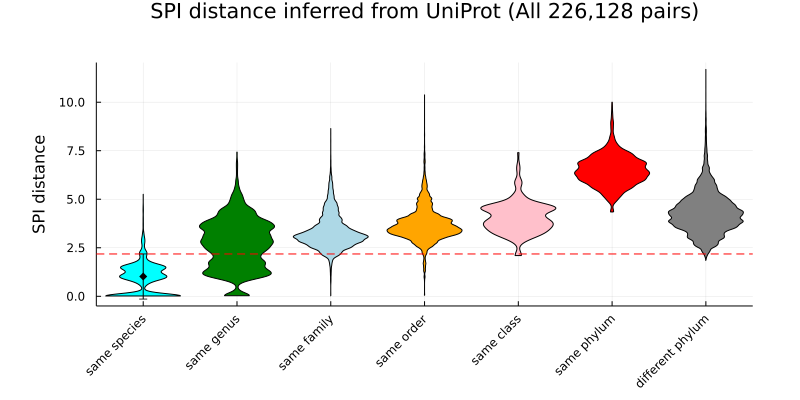

In [13]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="SPI distance inferred from UniProt (All 226,128 pairs)", ylabel="SPI distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = SPImtx
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [152]:
savefig(joinpath(pdir, "SPIdistUP_groupedby_NCBItaxonomy_violin.svg"))

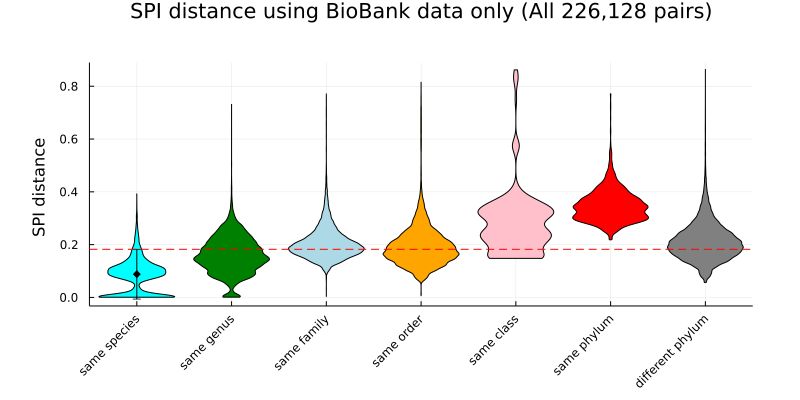

In [14]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="SPI distance using BioBank data only (All 226,128 pairs)", ylabel="SPI distance ", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = BBSPImtx
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [154]:
savefig(joinpath(pdir, "SPIdistBB_groupedby_NCBItaxonomy_violin.svg"))

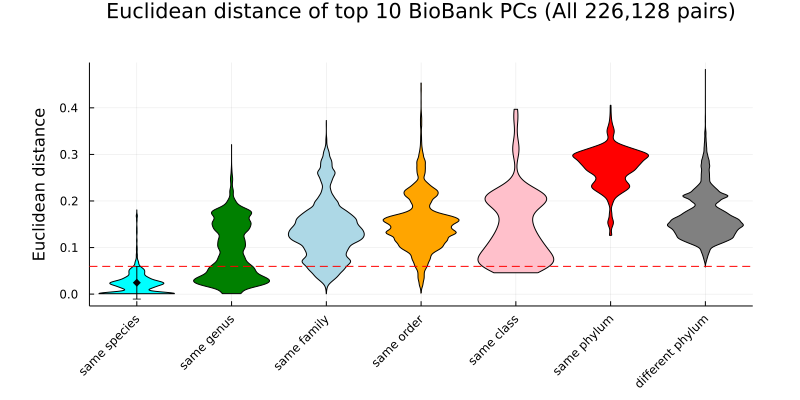

In [155]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Euclidean distance of top 10 BioBank PCs (All 226,128 pairs)", ylabel="Euclidean distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = BBsvdeuclideandistance
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [156]:
savefig(joinpath(pdir, "BBsvdeuclidean_groupedby_NCBItaxonomy_violin.svg"))

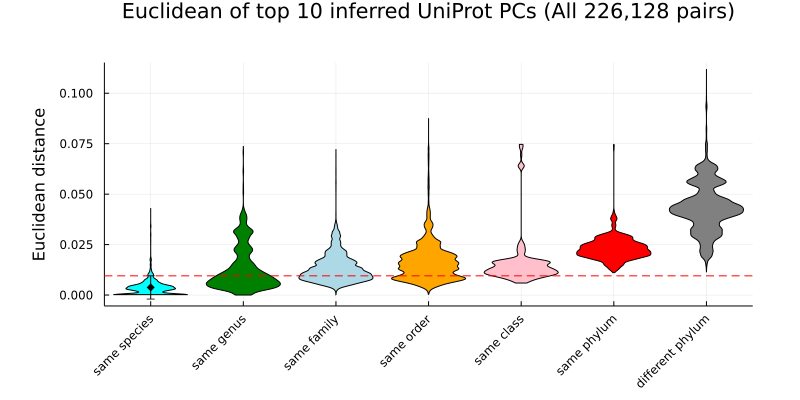

In [157]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Euclidean of top 10 inferred UniProt PCs (All 226,128 pairs)", ylabel="Euclidean distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = UPsvdeuclideandistance
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [158]:
savefig(joinpath(pdir, "UPsvdeuclidean_groupedby_NCBItaxonomy_violin.svg"))

In [128]:
xdata = taxanomicdistance
Nconflated = Float64[]
methodsmatrices = [SPImtx, BBSPImtx, BBsvdeuclideandistance, UPsvdeuclideandistance]
for ydata in methodsmatrices
    allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
    θ = 1.5std(allspeciesdists)
    for i in 1:6
        mask = xdata .== i
        push!(Nconflated, sum(ydata[mask] .< θ))
    end
end
Nconflated = reshape(Nconflated, (6,length(methodsmatrices)))

6×4 Matrix{Float64}:
 4197.0  5625.0  8767.0  9111.0
  238.0   212.0  1948.0  6266.0
  164.0  2452.0   894.0  3128.0
    0.0     0.0     0.0     2.0
    0.0     0.0     0.0     0.0
    0.0  5756.0     0.0     0.0

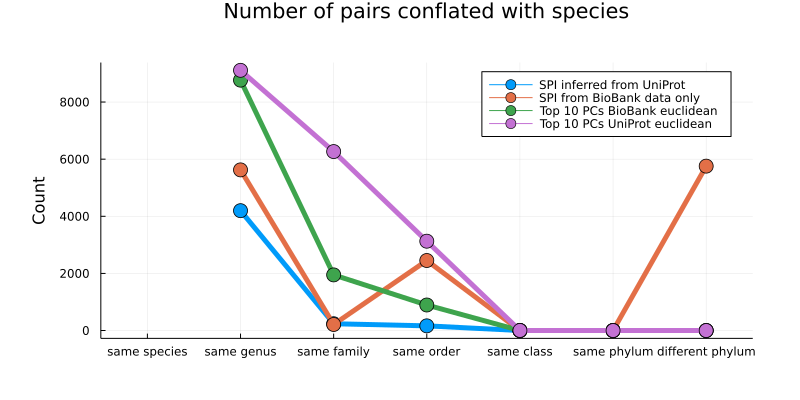

In [129]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Number of pairs conflated with species", ylabel="Count", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    # legend=:none,
)
plot!(2:7, 
    reshape(Nconflated, (6,length(methodsmatrices))), 
    label=["SPI inferred from UniProt" "SPI from BioBank data only" "Top 10 PCs BioBank euclidean" "Top 10 PCs UniProt euclidean" ], 
    lw=5, markersize=8, marker=true)

In [130]:
savefig(joinpath(pdir, "counts_of_pairs_conflated_with_species_by_distancemethod.svg"))

## Individual Metabolites

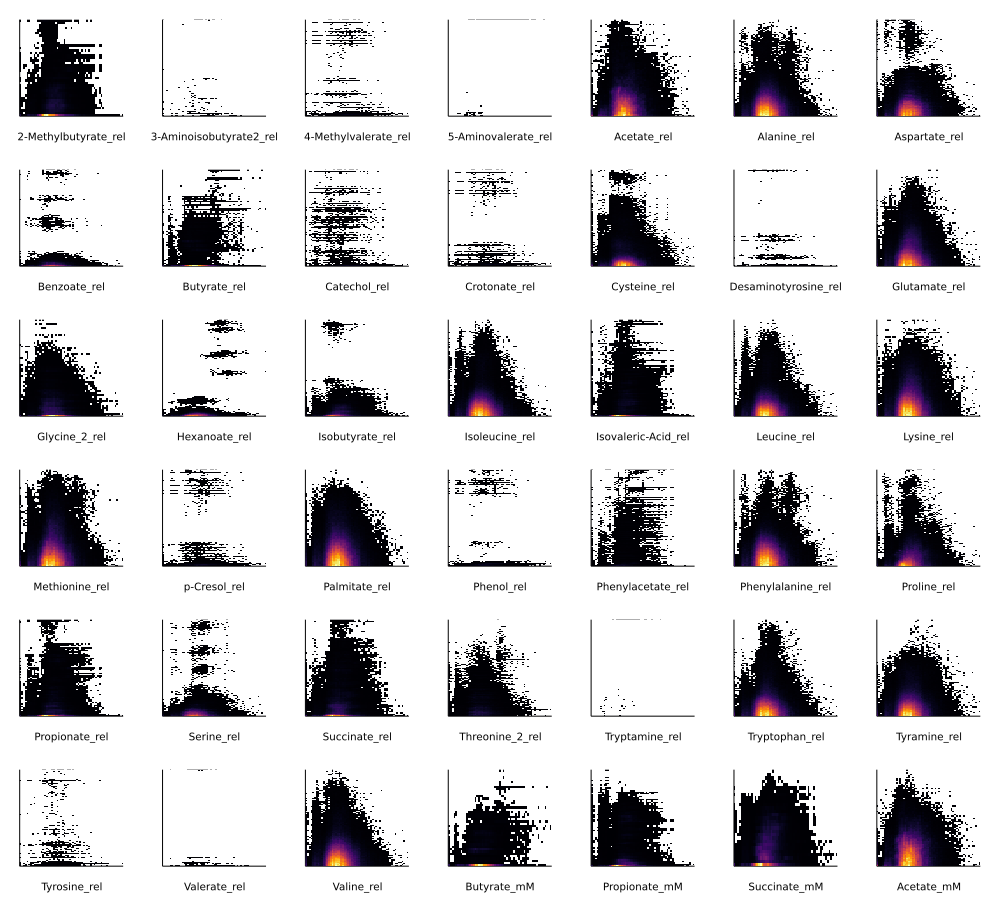

In [139]:
# individual metabolites
titles = vcat(biobank["metabolites_foldchange"].var_names, biobank["metabolites_millimolar"].var_names[1:4]);
metabolite_matrix = hcat(biobank["metabolites_foldchange"].X[:,:], biobank["metabolites_millimolar"].X[:,1:4]);
plot(layout=grid(6,7), size=(1000, 900), margin=3Plots.Measures.mm)
for i in 1:size(metabolite_matrix,2)
    mdist = Distances.pairwise(Euclidean(), metabolite_matrix[:,i]');
    xy = (SPImtx[uppertriangle], mdist[uppertriangle])
    histogram2d!(xy, xlabel=titles[i], xguidefontsize=7, sp=i, colorbar=:none, ticks=:none)
end
plot!()

In [140]:
savefig(joinpath(pdir, "x=SPIdist_y=individualmetabolitedistance_grid_heatmap.svg"))

In [15]:
vulgatusindicesBB = findall(bbtaxa.species .== "Phocaeicola vulgatus");
staphmask = BitVector(zeros(length(vulgatusindicesBB)))
staphmask[findfirst(s->contains(s, "MSK.7.24"), biobank.obs_names[vulgatusindicesBB])] = 1;
smalluppertriangle = triu(trues(length(vulgatusindicesBB)-1,length(vulgatusindicesBB)-1), 1);

In [16]:
binomial(89, 2)

3916

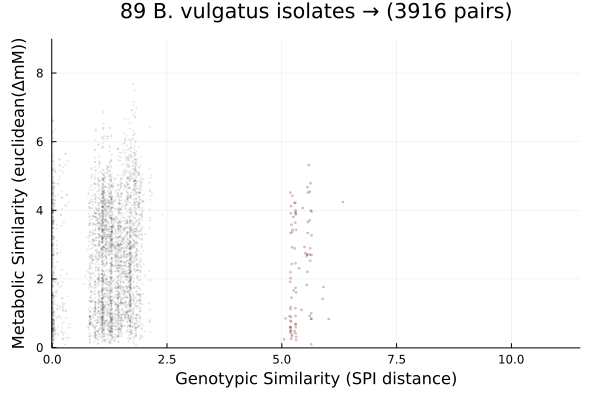

In [ ]:
plot(title="89 B. vulgatus isolates → (3916 pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Genotypic Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    ylims=(-0.01,9),
    xlims=(-0.01,11.5),
    )
scatter!(
    SPImtx[vulgatusindicesBB[.!staphmask],vulgatusindicesBB[.!staphmask]][smalluppertriangle], 
    metabolitedistance[vulgatusindicesBB[.!staphmask],vulgatusindicesBB[.!staphmask]][smalluppertriangle],
    alpha=0.1,
    markersize=2,
    label="",
    c=:black)
scatter!(
    SPImtx[vulgatusindicesBB[staphmask],vulgatusindicesBB[.!staphmask]], 
    metabolitedistance[vulgatusindicesBB[staphmask],vulgatusindicesBB[.!staphmask]],
    alpha=.2,
    markersize=2,
    label="",
    c=:red)

In [206]:
savefig(joinpath(pdir, "Bvulgatus_metabolic_by_SPIdistance_scatter.svg"))

In [ ]:
plot(title="673 BioBank isolates → (226,128 pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Genotypic Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    ylims=(-0.01,9),
    xlims=(-0.01,11.5))
scatter!(
    SPImtx[uppertriangle], 
    metabolitedistance[uppertriangle],
    alpha=0.1,
    markersize=2,
    label="",
    c=:black)

In [204]:
savefig(joinpath(pdir, "BB673_metabolic_by_SPIdistance_scatter.svg"))

## Number of pairs in 2d grid

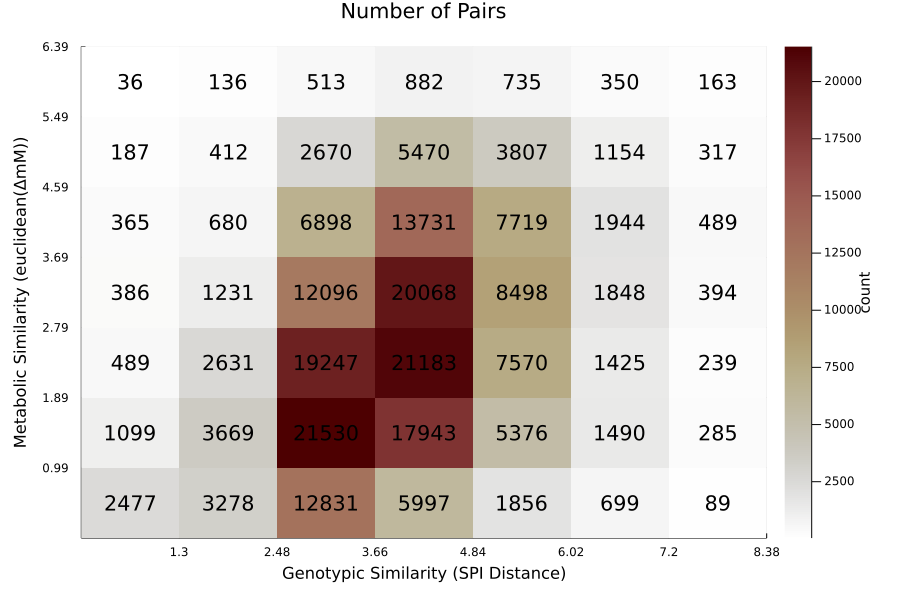

In [59]:
nbinsperside = 10 + 1
xy = (metabolitedistance[uppertriangle], SPImtx[uppertriangle])
ext = extrema.(xy)
edges = (
    range(0.0-1e-10, 9+1e-15, length=nbinsperside),
    range(0.0-1e-10, 11.8+1e-15, length=nbinsperside),
)
h2d = fit(Histogram, xy, edges)
outeredge = 7
marks = 1:1:outeredge
p1 = plot(
    size=(900,600),
    title="Number of Pairs",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (SPI Distance)",
    colorbartitle="count",
    yticks=(marks.+.5, round.(quantile(edges[1], (marks.+.1) ./10), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], (marks.+.1) ./10), digits=2)),
    margin=5Plots.Measures.mm)
p1 = heatmap!(h2d.weights[1:outeredge, 1:outeredge], c=:bilbao)
for i in CartesianIndices(h2d.weights[1:outeredge, 1:outeredge])
    annotate!(i[2], i[1], string(h2d.weights[i]))
end
plot!()

In [60]:
savefig(joinpath(pdir, "spi-by-met4mm_numpairs_100bins.svg"))

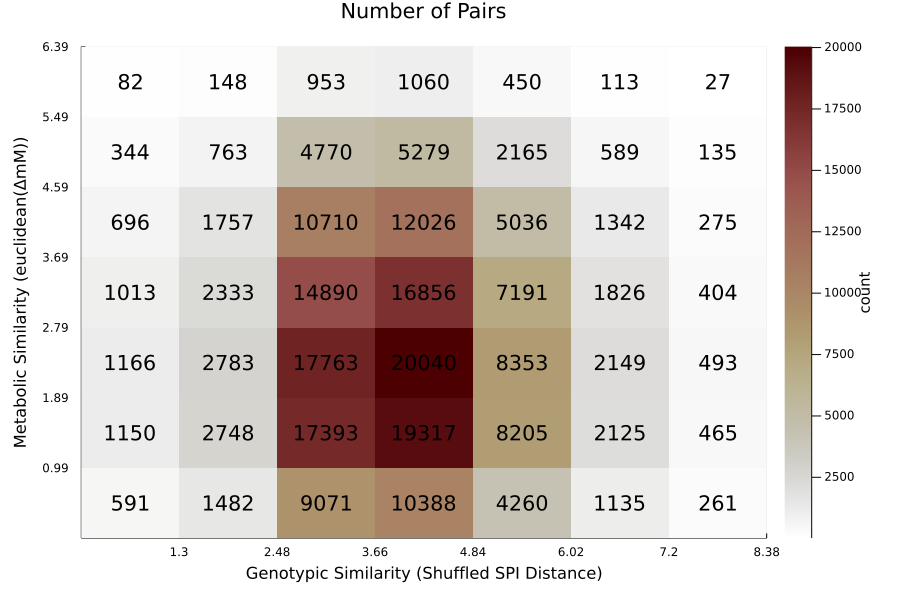

In [62]:
nbinsperside = 10 + 1
xy = (metabolitedistance[uppertriangle], shuffle(SPImtx[uppertriangle]))
ext = extrema.(xy)
edges = (
    range(0.0-1e-10, 9+1e-15, length=nbinsperside),
    range(0.0-1e-10, 11.8+1e-15, length=nbinsperside),
)
h2d = fit(Histogram, xy, edges)
outeredge = 7
marks = 1:1:outeredge
p1 = plot(
    size=(900,600),
    title="Number of Pairs",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (Shuffled SPI Distance)",
    colorbartitle="count",
    yticks=(marks.+.5, round.(quantile(edges[1], (marks.+.1) ./10), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], (marks.+.1) ./10), digits=2)),
    margin=5Plots.Measures.mm)
p1 = heatmap!(h2d.weights[1:outeredge, 1:outeredge], c=:bilbao)
for i in CartesianIndices(h2d.weights[1:outeredge, 1:outeredge])
    annotate!(i[2], i[1], string(h2d.weights[i]))
end
plot!()

In [63]:
savefig(joinpath(pdir, "spi-by-met4mm_numpairs_permutation_100bins.svg"))

## 2d Hist ratio fold change

In [28]:

BBsamephylum = bbtaxa.phylum .== permutedims(replace(bbtaxa.phylum, ""=>"missing"))
BBsameorder = bbtaxa.order .== permutedims(replace(bbtaxa.order, ""=>"missing"))
BBsamegenus = bbtaxa.genus .== permutedims(replace(bbtaxa.genus, ""=>"missing"))
# BBsamephylum = bbtaxa.phylum .== permutedims(bbtaxa.phylum)
# BBsameorder = bbtaxa.order .== permutedims(bbtaxa.order)
# BBsamegenus = bbtaxa.genus .== permutedims(bbtaxa.genus)
uppertriangle = triu(trues(size(BBsamegenus)), 1);

In [41]:
using Random: shuffle
using StatsBase
xy = (metabolitedistance[uppertriangle], SPImtx[uppertriangle])
ext = extrema.(xy)
# edges = Tuple(range(l-1e-15,h+1e-15, length=101) for (l, h) in ext)
edges = (
    range(0.0-1e-10, 9+1e-15, length=101),
    range(0.0-1e-10, 11.8+1e-15, length=101),
)
h2d = fit(Histogram, xy, edges)
phylumh2d = fit(Histogram, (metabolitedistance[BBsamephylum .& uppertriangle], SPImtx[BBsamephylum .& uppertriangle]), edges)
orderh2d = fit(Histogram, (metabolitedistance[BBsameorder .& uppertriangle], SPImtx[BBsameorder .& uppertriangle]), edges)
genush2d = fit(Histogram, (metabolitedistance[BBsamegenus .& uppertriangle], SPImtx[BBsamegenus .& uppertriangle]), edges);
notphylumh2d = fit(Histogram, (metabolitedistance[.!BBsamephylum .& uppertriangle], SPImtx[.!BBsamephylum .& uppertriangle]), edges);
notorderh2d = fit(Histogram, (metabolitedistance[.!BBsameorder .& uppertriangle], SPImtx[.!BBsameorder .& uppertriangle]), edges);
notgenush2d = fit(Histogram, (metabolitedistance[.!BBsamegenus .& uppertriangle], SPImtx[.!BBsamegenus .& uppertriangle]), edges);


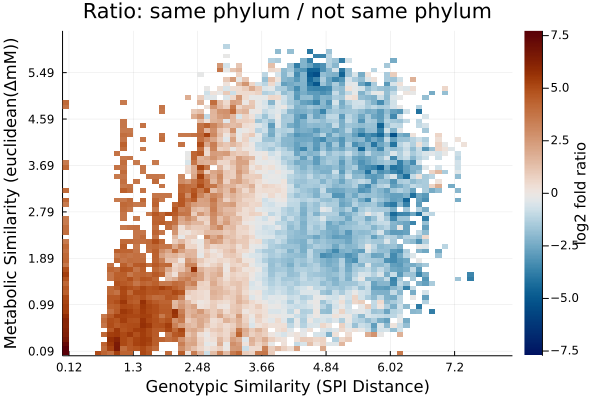

In [33]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same phylum / not same phylum",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )
foldchange_mtx = log2.((phylumh2d.weights.+1) ./ (notphylumh2d.weights.+1))
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = phylumh2d.weights .+ notphylumh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)


In [216]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Phylum-ratio_heatmap.svg"))

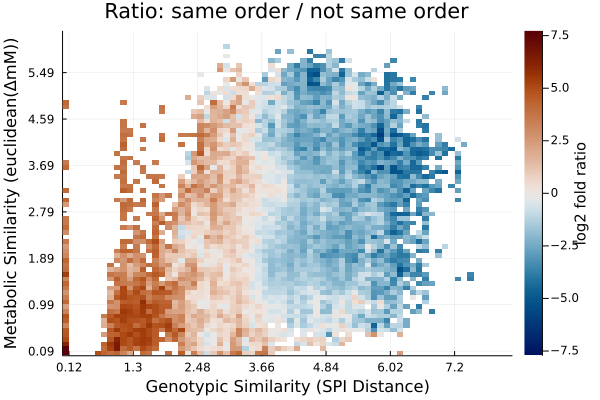

In [217]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same order / not same order",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((orderh2d.weights.+1) ./ (notorderh2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = orderh2d.weights .+ notorderh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)

In [218]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Order-ratio_heatmap.svg"))

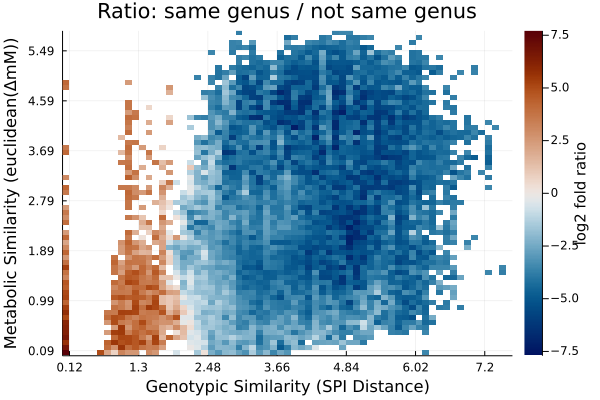

In [220]:
outeredge = 65
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same genus / not same genus",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((genush2d.weights.+1) ./ (notgenush2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = genush2d.weights .+ notgenush2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)
# heatmap!(foldchange_mtx, clims=working_clims, c=:vik)



In [221]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Genus-ratio_heatmap.svg"))

## permute pairs (log2 ratio)

In [222]:
using Random: shuffle
SPImtx_shuff = shuffle(SPImtx)
metabolitedistance_shuff = shuffle(metabolitedistance)
xy = (metabolitedistance[trilmask], SPImtx_shuff[trilmask])
ext = extrema.(xy)
# edges = Tuple(range(l-1e-15,h+1e-15, length=101) for (l, h) in ext)
edges = (
    range(0.0-1e-10, 9+1e-15, length=101),
    range(0.0-1e-10, 11.8+1e-15, length=101),
)
h2d = fit(Histogram, xy, edges)
phylumh2d = fit(Histogram, (metabolitedistance[BBsamephylum .& trilmask], SPImtx_shuff[BBsamephylum .& trilmask]), edges)
orderh2d = fit(Histogram, (metabolitedistance[BBsameorder .& trilmask], SPImtx_shuff[BBsameorder .& trilmask]), edges)
genush2d = fit(Histogram, (metabolitedistance[BBsamegenus .& trilmask], SPImtx_shuff[BBsamegenus .& trilmask]), edges);
notphylumh2d = fit(Histogram, (metabolitedistance[.!BBsamephylum .& trilmask], SPImtx_shuff[.!BBsamephylum .& trilmask]), edges);
notorderh2d = fit(Histogram, (metabolitedistance[.!BBsameorder .& trilmask], SPImtx_shuff[.!BBsameorder .& trilmask]), edges);
notgenush2d = fit(Histogram, (metabolitedistance[.!BBsamegenus .& trilmask], SPImtx_shuff[.!BBsamegenus .& trilmask]), edges);


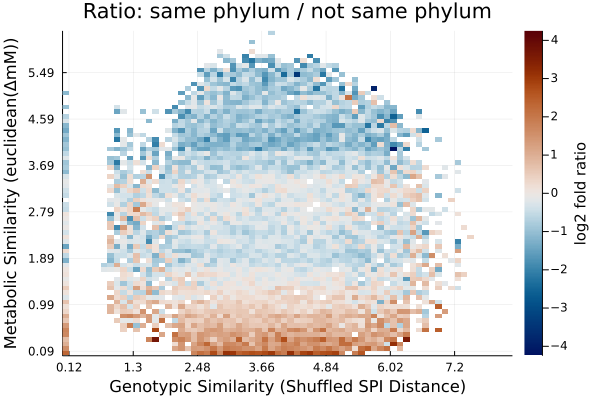

In [227]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same phylum / not same phylum",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (Shuffled SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )
foldchange_mtx = log2.((phylumh2d.weights.+1) ./ (notphylumh2d.weights.+1))
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = phylumh2d.weights .+ notphylumh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)


In [228]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Phylum-ratio_permutation_heatmap.svg"))

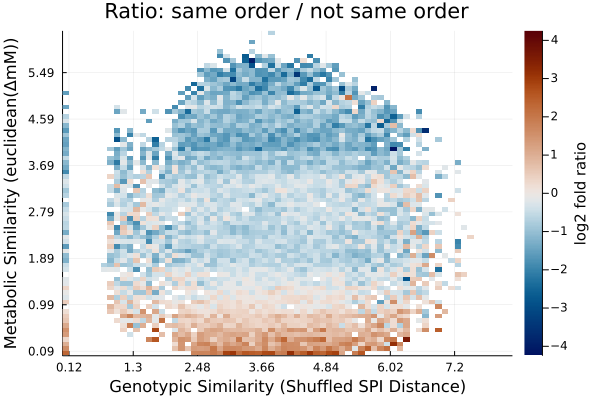

In [229]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same order / not same order",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (Shuffled SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((orderh2d.weights.+1) ./ (notorderh2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = orderh2d.weights .+ notorderh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)


In [230]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Order-ratio_permutation_heatmap.svg"))

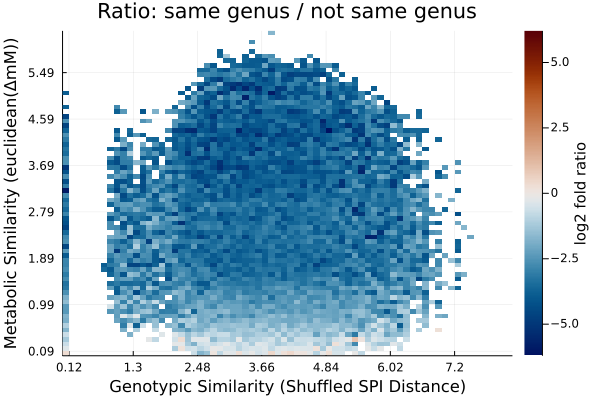

In [231]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same genus / not same genus",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Genotypic Similarity (Shuffled SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((genush2d.weights.+1) ./ (notgenush2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = genush2d.weights .+ notgenush2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)
# heatmap!(foldchange_mtx, clims=working_clims, c=:vik)


In [232]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Genus-ratio_permutation_heatmap.svg"))